# **FIFA 19 CLASSIFICATION DL**

Integrantes del grupo:


*   Nicolas Vega
*   Pablo Martin
*   Jorge Saenz de Miera






#IMPORTS AND FUNCTIONS

Sabemos que esta parte no es evaluable, aun asi adjuntamos las funciones creadas y usadas para la creacion y evalucacion de los modelos que vayamos generando por si se requiere en algun momento.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
from sklearn.metrics import classification_report
print("Tensorflow version: "+tf.__version__)


def eval_model(model): 
  results = pd.DataFrame(model.history)
  results.plot(figsize = (8, 5))
  plt.grid(True)
  plt.xlabel ("Epochs")
  plt.ylabel ("Accuracy - Mean Log Loss")
  plt.gca().set_ylim(0, 1) # set the vertical range to [0,1]
  plt.show()

  print(results[-1:])
  print()
  print("Error (training): ", round((1 - results.categorical_accuracy.values[-1:][0])*100, 1), "%")
  print("Error (development): ", round((1 - results.val_categorical_accuracy.values[-1:][0])*100, 1), "%")
  print()
  print("Accuracy (training): ", results.categorical_accuracy.values[-1:][0]*100 , "%")
  print("Accuracy (development): ", results.val_categorical_accuracy.values[-1:][0]*100 , "%")

def create_classif_model(name,n_neurons_per_hidden_layer, lr, activation, n_epochs, **kwargs):

  initializer = kwargs.get('initializer', 'glorot_uniform')
  batch_size = kwargs.get('batch_size', None)
  metrics = kwargs.get('metrics', ["categorical_accuracy"])
  regularizer = kwargs.get('regularizer', None)
  optimizer = kwargs.get('optimizer', tf.keras.optimizers.SGD(learning_rate=lr))
  dropout = kwargs.get('dropout', False)

  if dropout == False:
    model = keras.Sequential(name=name)
    model.add(keras.layers.InputLayer(input_shape=(INPUTS,)))
    for neurons in n_neurons_per_hidden_layer:
      model.add(keras.layers.Dense(neurons, activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer))
    model.add(keras.layers.Dense(OUTPUTS, activation="softmax"))

  else:    
    model = keras.Sequential(name='name')
    model.add(keras.layers.InputLayer(input_shape=(INPUTS,)))
    for neurons in n_neurons_per_hidden_layer:
      model.add(keras.layers.Dense(neurons, activation=activation, kernel_initializer=initializer))
      model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(OUTPUTS, activation="softmax"))

  model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer= optimizer, metrics=metrics)

  start_time = time.perf_counter()

  model_fit = model.fit(x_train, t_train, 
                    batch_size = batch_size, 
                    epochs=n_epochs, 
                    verbose = 0, 
                    validation_data = (x_dev, t_dev))

  print('Fit time: ',str(datetime.timedelta(seconds=time.perf_counter() - start_time)))
  print()
  score = model.evaluate(x_dev, t_dev, verbose=0)
  print('Development loss:', score[0]) 
  print('Development categorical accuracy:', score[1])

  results = model.predict(x_dev, verbose=0)
  dev_sparse_predictions = np.argmax(results,1)
  dev_sparse_targets = np.argmax(t_dev, axis=1)

  print('Classification Report')
  classes = ['Poor','Interm','Good','Excel']
  print(classification_report(dev_sparse_targets, dev_sparse_predictions, target_names=classes))
  eval_model(model_fit)

  return model


    
data = pd.read_csv('ATT_FILE_NAME.csv')
label = pd.read_csv('ONE_HOT_ENCODED_CLASSES_FILE_NAME.csv')

TRAIN_RATIO = 0.8

n_instances = data.shape[0]
n_train = int(n_instances*TRAIN_RATIO)
n_dev = int((n_instances - n_train)/2)

x_train = data.values[:n_train]
t_train = label.values[:n_train]

x_dev =   data.values[n_train:n_train + n_dev]
t_dev =   label.values[n_train:n_train + n_dev]

x_test =  data.values[-n_dev:]
t_test =  label.values[-n_dev:]


INPUTS =  x_train.shape[1]
OUTPUTS = t_train.shape[1]

NUM_TRAINING_EXAMPLES = int(round(x_train.shape[0]/1))
NUM_DEV_EXAMPLES =      int(round(x_dev.shape[0]/1))
NUM_TEST_EXAMPLES =      int(round(x_test.shape[0]/1))


print ("Number of instances: ", n_instances)
print ("Number of training examples: ", NUM_TRAINING_EXAMPLES)
print ("Number of examples for development test: ", NUM_DEV_EXAMPLES)
print ("Number of examples for test: ", NUM_TEST_EXAMPLES)

Tensorflow version: 2.12.0
Number of instances:  16122
Number of training examples:  12897
Number of examples for development test:  1612
Number of examples for test:  1612


Puesto que no existe un consenso sobre como seleccionar la arquitectura neuronal mas adecuada nosotros probaremos con distintas arquitecturas, mejorando y aumentando la complejidad de estas segun sea necesario.

Vamos a plantear 2 arquitecturas neuronales distintas:

*   Embudo: De mas a menos neuronas por capa ([5,4,3,2,1])
*   Alternada: Alternamos entre 2 capas de distinto numero de neuronas ([2,1,2,1,2])

Obteniendo los mismos resultados es preferible un modelo sencillo a uno muy complejo, por ello escogemos esta estrategia, en la que comenzaremos probando con modelos sencilos e iremos aumentando paulatinamente la complejidad del modelo segun los resultados obtenidos siguiendo las pautas indicadas por la guia vista en clase. 

Iremos variando los hiperparametros para encontrar el mejor modelo, siempre empezando por uno sencillo, sin uso de optimizadores, regularizadores, mini-batch, dropout, etc. Aun asi, habra ciertos hiperparametros que mantendremos constantes al tener una base matematica que fundamenta su eleccion en el tipo de problema que nos ocupa, clasificacion.

Obviamente al tratarse de una red neuronal ante un problema de clasificacion haremos uso de una funcion de activacion 'softmax' en la ultima capa. En el resto de capas usaremos la funcion 'ReLu' tratando de paliar el problema que tiene la retropropagacion del gradiente con funciones de activacion que se saturan en los extremos como pueden ser la 'tanh'.

En cuanto a la learning rate, hemos comprobado en un primer analisis que valores superiores a 0.0005 producen mayores variaciones en el error y funcion perdida en cada epoca (zigzags en las graficas).


En ocasiones hacemos uso de inicializadores ya que teoricamente es una forma de alcanzar minimos en  la funcion de coste de forma mas rapida, inicializando los pesos segun una distribucion en vez de forma aleatoria. Usamos el inicializador 'He uniform' puesto que hemos visto que da buenos resultados y se recomienda su uso junto a la funcion de activacion 'ReLu'

#ARQUITECTURA EMBUDO

##[25,15,7,5]

En primer lugar probamos con una arquitecura sencilla, con tan solo 4 capas ocultas. El numero de neuronas por capa hacemos que disminuya a lo largo de las capas (embudo) y escogemos empezar con 25 neuronas en la primera capa pues queremos que el numero medio de neuronas por capa ronde el numero de variables de nuestro dataset (visto como sugerencia).  



Fit time:  0:29:22.636589

Development loss: 0.43049323558807373
Development categorical accuracy: 0.8163771629333496
Classification Report
              precision    recall  f1-score   support

        Poor       0.91      0.86      0.88       439
      Interm       0.73      0.73      0.73       408
        Good       0.76      0.79      0.77       434
       Excel       0.88      0.90      0.89       331

    accuracy                           0.82      1612
   macro avg       0.82      0.82      0.82      1612
weighted avg       0.82      0.82      0.82      1612



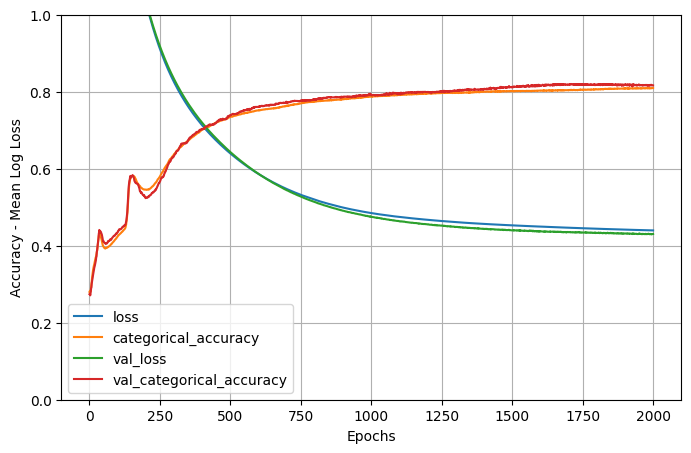

          loss  categorical_accuracy  val_loss  val_categorical_accuracy
1999  0.439765              0.809491  0.430493                  0.816377

Error (training):  19.1 %
Error (development):  18.4 %

Accuracy (training):  80.94905614852905 %
Accuracy (development):  81.63771629333496 %


In [ ]:
n_neurons_per_hidden_layer = [25,15,7,5]
lr = 0.0001
activation = "relu"
n_epochs = 2000

final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs)


Observamos que tenemos un bias alto (9.1%) y una varianza negativa, si no nula.La varianza no creemos que pueda ser negativa, lo que entendemos es que si continuasemos entrenando el modelo ambas accuracy (y consecuentemente los errores) convergerian a al mismo valor (el de validacion en estos casos) y la varianza tenderia a 0. Esto sucedera en mas ocasiones a lo largo de la busqueda de mejor modelo y consideraremos que la varianza es nula en estos casos, no negativa.


La accuracy es mala, parece que la estructura no es lo suficiente compleja y que necesitamos mas capas y neuronas. Aun asi probamos a disminuir el bias  usando el optimizador Nesterov, el que conceptualmente mas nos convence aprovechando la ventaja que da el momentum combinado con un vector mas preciso. Aun asi exploraremos otros optimizadores.





###NAG

Fit time:  0:12:41.368883

Development loss: 0.4145207703113556
Development categorical accuracy: 0.8213399648666382
Classification Report
              precision    recall  f1-score   support

        Poor       0.91      0.87      0.89       439
      Interm       0.73      0.74      0.73       408
        Good       0.78      0.78      0.78       434
       Excel       0.89      0.92      0.90       331

    accuracy                           0.82      1612
   macro avg       0.82      0.83      0.82      1612
weighted avg       0.82      0.82      0.82      1612



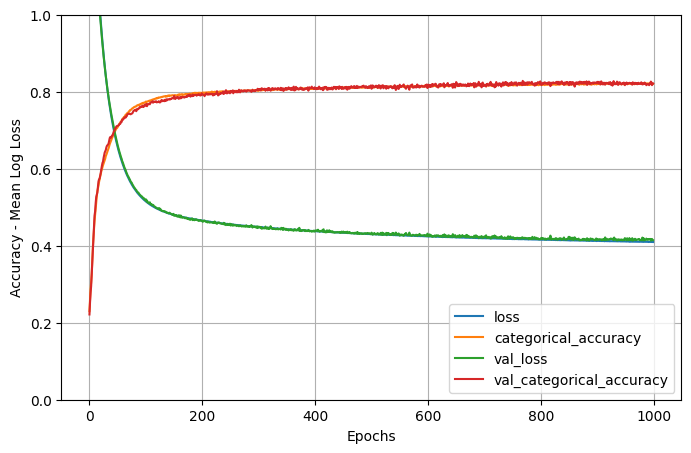

         loss  categorical_accuracy  val_loss  val_categorical_accuracy
999  0.409621              0.820346  0.414521                   0.82134

Error (training):  18.0 %
Error (development):  17.9 %

Accuracy (training):  82.03458189964294 %
Accuracy (development):  82.13399648666382 %


In [ ]:
n_neurons_per_hidden_layer = [25,15,7,5]
lr = 0.0001
activation = "relu"
n_epochs = 1000
kwargs = {'optimizer': tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.85, nesterov=True),
          'initializer': keras.initializers.he_uniform(seed=127)
          }

final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs, **kwargs)




Obtenemos mejores resultados, el bias lo hemos reducido a un 8% y la varianza es nula (habiendo mayor accuracy en validacion que en entrenamiento). 

Como podemos observar en la grafica no se produce overfitting, pero parece que se estan formando asintotas tanto en accuracy como en loss. Sin aumentar la arquitectura neuronal no podemos reducir mas el bias, ni tampoco podemos mejorar una varianza inexistente, por lo que el modelo no parece mejorable.

Probamos con el optimizador 'Adam'

###ADAM

Fit time:  0:19:28.088323

Development loss: 0.4111613929271698
Development categorical accuracy: 0.8145161271095276
Classification Report
              precision    recall  f1-score   support

        Poor       0.91      0.87      0.89       439
      Interm       0.74      0.71      0.72       408
        Good       0.75      0.78      0.77       434
       Excel       0.87      0.92      0.89       331

    accuracy                           0.81      1612
   macro avg       0.82      0.82      0.82      1612
weighted avg       0.82      0.81      0.81      1612



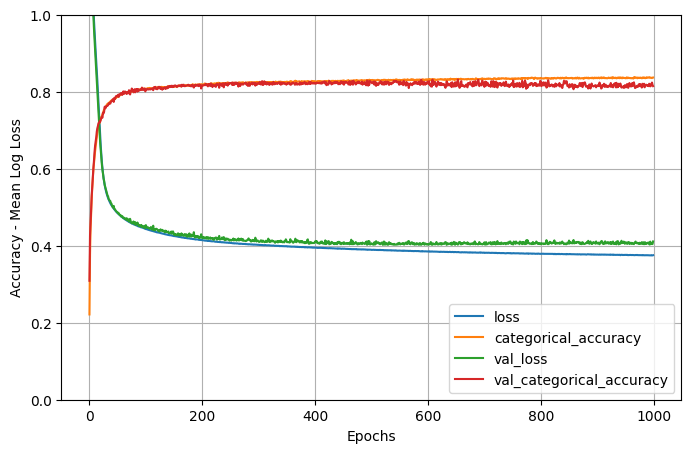

         loss  categorical_accuracy  val_loss  val_categorical_accuracy
999  0.375302              0.836861  0.411161                  0.814516

Error (training):  16.3 %
Error (development):  18.5 %

Accuracy (training):  83.68613123893738 %
Accuracy (development):  81.45161271095276 %


In [ ]:
n_neurons_per_hidden_layer = [25,15,7,5]
lr = 0.0001
activation = "relu"
n_epochs = 1000
kwargs = {'optimizer': tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.99),
          'initializer': keras.initializers.he_uniform(seed=127)
          }

final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs, **kwargs)






Observamos que hemos mejorado significativamente el bias a 6.3%, sin embargo la varianza aumenta a un 2.2%.  

Aplicaremos un regularizador para tratar de disminuir la varianza. Hacemos uso de regularizadores en vez de dropout ya que esta es una red neuronal pequeña, y si aplicasemos dropout habria pocas neuronas activas. En redes mas complejas nos podremos plantear su utilizacion.

####REG. L1

Fit time:  0:27:23.300412

Development loss: 0.45260190963745117
Development categorical accuracy: 0.8275434374809265
Classification Report
              precision    recall  f1-score   support

        Poor       0.90      0.88      0.89       439
      Interm       0.75      0.75      0.75       408
        Good       0.78      0.79      0.78       434
       Excel       0.90      0.90      0.90       331

    accuracy                           0.83      1612
   macro avg       0.83      0.83      0.83      1612
weighted avg       0.83      0.83      0.83      1612



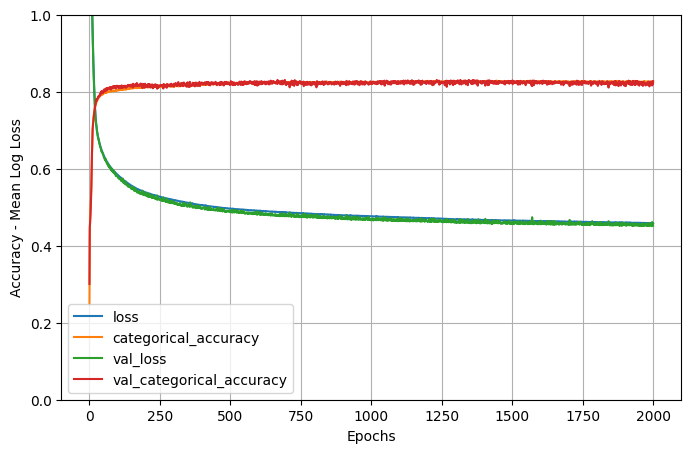

          loss  categorical_accuracy  val_loss  val_categorical_accuracy
1999  0.457975              0.825308  0.452602                  0.827543

Error (training):  17.5 %
Error (development):  17.2 %

Accuracy (training):  82.53082036972046 %
Accuracy (development):  82.75434374809265 %


In [ ]:
n_neurons_per_hidden_layer = [25,15,7,5]
lr = 0.0001
activation = "relu"
n_epochs = 2000
kwargs = {'optimizer': tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.99),
          'initializer': keras.initializers.he_uniform(seed=127),
          'regularizer': keras.regularizers.l1(0.001)
          }

final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs, **kwargs)




Observamos como el bias ha aumentado a un 7.5%, 1.2% mas que la version sin regularizador, la varianza es nula. 

Nos encontramos en el mismo caso que antes, el modelo no parece mejorable sin variar la arquitectura neuronal.



###RMSProp

Fit time:  0:13:23.284221

Development loss: 0.4256803095340729
Development categorical accuracy: 0.8219602704048157
Classification Report
              precision    recall  f1-score   support

        Poor       0.90      0.90      0.90       439
      Interm       0.76      0.74      0.75       408
        Good       0.76      0.77      0.77       434
       Excel       0.88      0.88      0.88       331

    accuracy                           0.82      1612
   macro avg       0.82      0.82      0.82      1612
weighted avg       0.82      0.82      0.82      1612



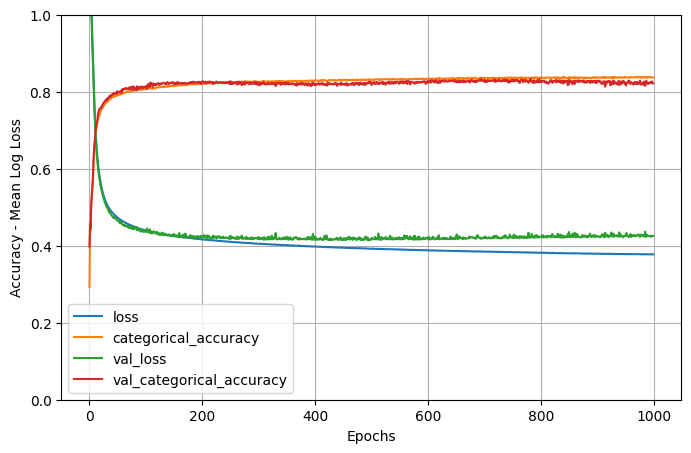

         loss  categorical_accuracy  val_loss  val_categorical_accuracy
999  0.377678              0.836706   0.42568                   0.82196

Error (training):  16.3 %
Error (development):  17.8 %

Accuracy (training):  83.67062211036682 %
Accuracy (development):  82.19602704048157 %


In [ ]:
n_neurons_per_hidden_layer = [25,15,7,5]
lr = 0.0001
activation = "relu"
n_epochs = 1000
kwargs = {'optimizer': tf.keras.optimizers.RMSprop(learning_rate=lr, rho=0.9),
          'initializer': keras.initializers.he_uniform(seed=127)
          }

final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs, **kwargs)




Obtenemos los mejores resultados hasta ahora con un bias de un 6.3% y una varianza de 1.5%. 

Tratamos de reducir la varianza mediante el uso de regularizadores.

####REG L1

Fit time:  0:13:06.532605

Development loss: 0.4793936312198639
Development categorical accuracy: 0.82444167137146
Classification Report
              precision    recall  f1-score   support

        Poor       0.91      0.88      0.89       439
      Interm       0.76      0.73      0.74       408
        Good       0.77      0.79      0.78       434
       Excel       0.87      0.91      0.89       331

    accuracy                           0.82      1612
   macro avg       0.83      0.83      0.83      1612
weighted avg       0.82      0.82      0.82      1612



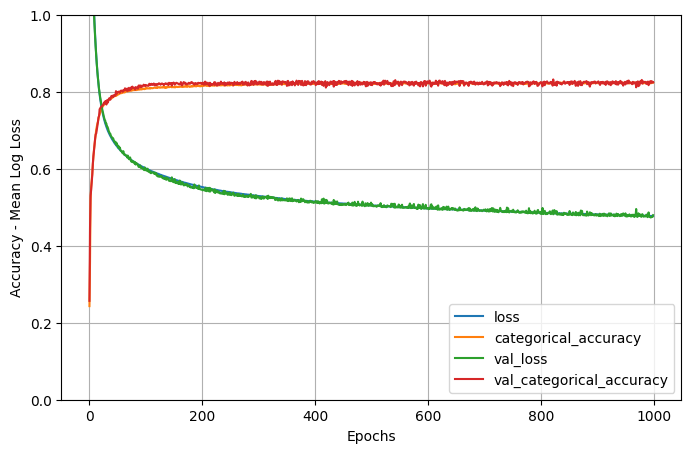

         loss  categorical_accuracy  val_loss  val_categorical_accuracy
999  0.477423               0.82368  0.479394                  0.824442

Error (training):  17.6 %
Error (development):  17.6 %

Accuracy (training):  82.36799240112305 %
Accuracy (development):  82.444167137146 %


In [ ]:
n_neurons_per_hidden_layer = [25,15,7,5]
lr = 0.0001
activation = "relu"
n_epochs = 1000
kwargs = {'optimizer': tf.keras.optimizers.RMSprop(learning_rate=lr, rho=0.9),
          'initializer': keras.initializers.he_uniform(seed=127),
          'regularizer': keras.regularizers.l1(0.001)
          }

final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs, **kwargs)




Obtenemos unos resultados mejores. Es cierto que el bias a aumentado a 7.6%,frente al 6.1% sin el uso del regulizador, pero la varianza ahora es nula. 

La mayor accuracy obtenida en el conjunto de validacion ha sido de un 82.44%, no es un mal resultado pero creemos que es mejorable aumentando la complejidad del modelo aumentando el numero de neuronas y/o capas. Aun asi, para ser un modelo tan sencillo, con pocas neuronas, hemos obtenido unos resultados bastante decentes.

##[250, 150, 75, 25]


Antes de aumentar el numero de capas para alcanzar la complejidad necesaria acorde al conjunto de datos, aumentamos el numero de neuronas por capa, comprobando si de esta forma logramos alcanzar dicha complejidad de forma mas eficiente, ya que es computacionalmente menos costoso el aumento de neuronas por capa que el aumento en numero de capas (ante mismo numero de neuronas total).

Fit time:  0:15:47.313409

Development loss: 0.4279134273529053
Development categorical accuracy: 0.8163771629333496
Classification Report
              precision    recall  f1-score   support

        Poor       0.91      0.88      0.89       439
      Interm       0.74      0.74      0.74       408
        Good       0.76      0.77      0.76       434
       Excel       0.86      0.89      0.88       331

    accuracy                           0.82      1612
   macro avg       0.82      0.82      0.82      1612
weighted avg       0.82      0.82      0.82      1612



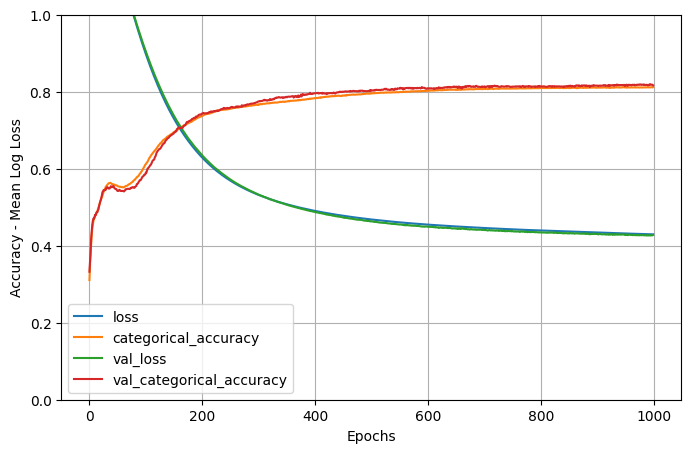

         loss  categorical_accuracy  val_loss  val_categorical_accuracy
999  0.429582              0.811739  0.427913                  0.816377

Error (training):  18.8 %
Error (development):  18.4 %

Accuracy (training):  81.17391467094421 %
Accuracy (development):  81.63771629333496 %


In [ ]:
n_neurons_per_hidden_layer = [250, 150, 75, 25]
lr = 0.0001
activation = "relu"
n_epochs = 1000

final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs)


En una primera ejecucion, sin uso de optimizador, no mejoramos los resultados anteriores.

El bias es alto (8.8%) y la varianza  nula. 

Incorporamos un optimizador para disminuir el bias.

###NAG

Fit time:  0:06:41.639014

Development loss: 0.4099462628364563
Development categorical accuracy: 0.8349875807762146
Classification Report
              precision    recall  f1-score   support

        Poor       0.91      0.90      0.90       439
      Interm       0.78      0.74      0.76       408
        Good       0.77      0.82      0.80       434
       Excel       0.89      0.89      0.89       331

    accuracy                           0.83      1612
   macro avg       0.84      0.84      0.84      1612
weighted avg       0.84      0.83      0.83      1612



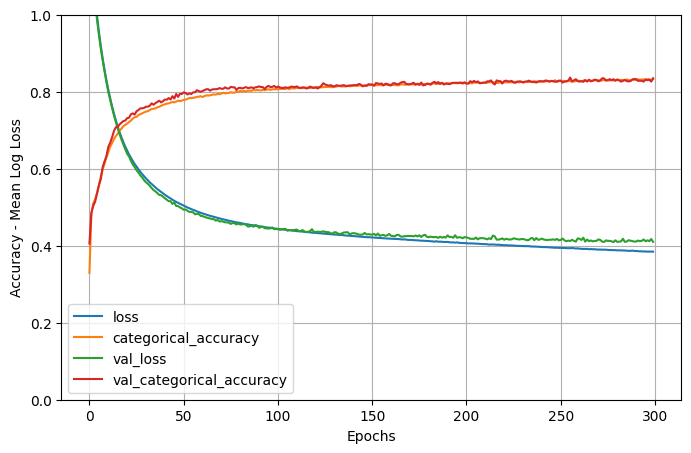

         loss  categorical_accuracy  val_loss  val_categorical_accuracy
299  0.384577              0.832597  0.409946                  0.834988

Error (training):  16.7 %
Error (development):  16.5 %

Accuracy (training):  83.25967192649841 %
Accuracy (development):  83.49875807762146 %


In [ ]:
n_neurons_per_hidden_layer = [250, 150, 75, 25]
lr = 0.0001
activation = "relu"
n_epochs = 300

kwargs = {'optimizer': tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.85, nesterov=True),
          'initializer': keras.initializers.he_uniform(seed=127)
          }

final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs, **kwargs)



Observamos como los resultados han mejorado notablemente. El bias ha disminuido a un 6.7% y la varianza es nula. Se trata del mejor modelo hasta ahora, con una accuracy en validacion de un 83.5%



###RMSprop

Fit time:  0:00:31.918959

Development loss: 0.41470685601234436
Development categorical accuracy: 0.8306451439857483
Classification Report
              precision    recall  f1-score   support

        Poor       0.90      0.91      0.90       439
      Interm       0.79      0.71      0.75       408
        Good       0.77      0.80      0.78       434
       Excel       0.87      0.92      0.89       331

    accuracy                           0.83      1612
   macro avg       0.83      0.83      0.83      1612
weighted avg       0.83      0.83      0.83      1612



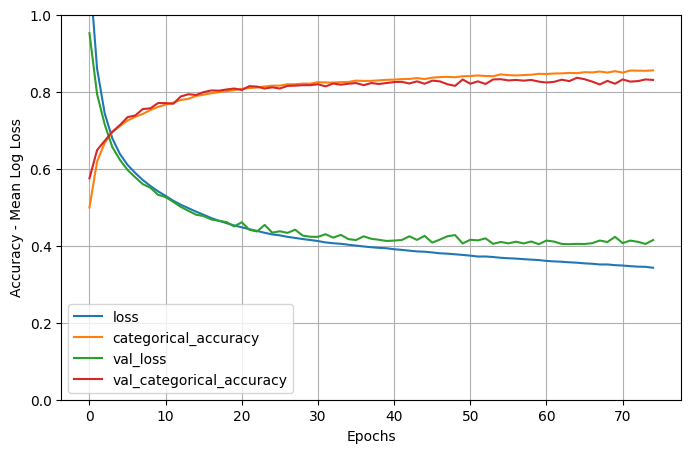

        loss  categorical_accuracy  val_loss  val_categorical_accuracy
74  0.342755               0.85547  0.414707                  0.830645

Error (training):  14.5 %
Error (development):  16.9 %

Accuracy (training):  85.54702401161194 %
Accuracy (development):  83.06451439857483 %


In [ ]:
n_neurons_per_hidden_layer = [250, 150, 75, 25]
lr = 0.0001
activation = "relu"
n_epochs = 75

kwargs = {'optimizer': tf.keras.optimizers.RMSprop(learning_rate=lr, rho=0.9),
          'initializer': keras.initializers.he_uniform(seed=127),
          'batch_size': 128
          }

final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs, **kwargs)


Vemos que hemos logrado disminuir el bias a un 4.5%, sin embargo la varianza es alta, 2.4%. Aplicamos un regularizador para tratar de disminuirla.


####REG L1

Fit time:  0:00:51.534790

Development loss: 0.9016322493553162
Development categorical accuracy: 0.8194789290428162
Classification Report
              precision    recall  f1-score   support

        Poor       0.88      0.93      0.90       439
      Interm       0.74      0.72      0.73       408
        Good       0.77      0.76      0.76       434
       Excel       0.89      0.88      0.88       331

    accuracy                           0.82      1612
   macro avg       0.82      0.82      0.82      1612
weighted avg       0.82      0.82      0.82      1612



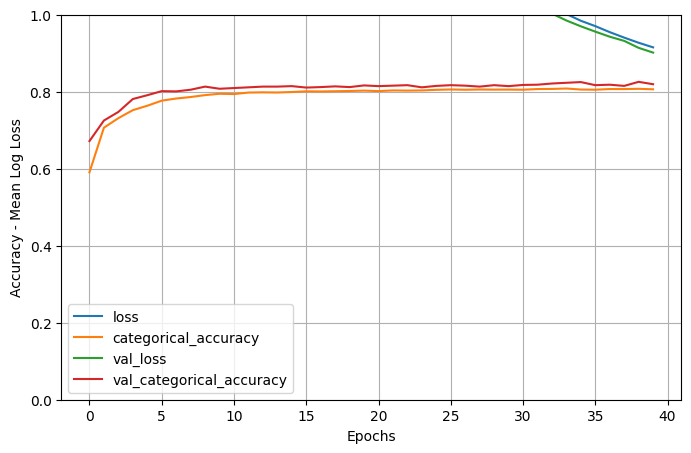

        loss  categorical_accuracy  val_loss  val_categorical_accuracy
39  0.915234              0.806312  0.901632                  0.819479

Error (training):  19.4 %
Error (development):  18.1 %

Accuracy (training):  80.6311547756195 %
Accuracy (development):  81.94789290428162 %


In [ ]:
n_neurons_per_hidden_layer = [250, 150, 75, 25]
lr = 0.0001
activation = "relu"
n_epochs = 40

kwargs = {'optimizer': tf.keras.optimizers.RMSprop(learning_rate=lr, rho=0.9),
          'initializer': keras.initializers.he_uniform(seed=127),
          'regularizer': keras.regularizers.l1(0.001)
          }

final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs, **kwargs)


Da igual que regularizador usemos que obtendremos unos resultados bastante malos. En esta ultima ejecucion obtenemos un bias altisimo de un 9.4%, la varianza es nula.

Con esta estructura hemos llegado a obtener un modelo francamente bueno, haciendo uso del optimizador Nesterov obteniendo un 83.5% de accuracy en validacion. Es cierto que hemos logrado un bias menor usando el optimizador RMSProp, pero a costa de aumentar la varianza al sobreentrenar ligeramente el modelo. 

Consideramos que es mejor modelo el que usa el optimizador Nesterov ya que a pesar de que el bias sea ligeramente mas alto (2.2%), la varianza la hemos reducido de 2.4% a 0%.

Aun asi queremos mejorar aun mas la accuracy, pero al haber reducido al maximo el bias (manteniendo una varianza aceptable) nos planteamos probar con redes mas profundas aumentando la complejidad del modelo.

##[500, 350, 250, 120, 75]

Aumentamos aun mas la complejidad del modelo. Continuamos con una arquitectura en forma de embudo pero con mayor numero de capas y neuronas por capa, comenzando con 500 neuronas en la primera capa.

Fit time:  0:33:07.943435

Development loss: 0.41852930188179016
Development categorical accuracy: 0.8256824016571045
Classification Report
              precision    recall  f1-score   support

        Poor       0.91      0.89      0.90       439
      Interm       0.76      0.74      0.75       408
        Good       0.77      0.79      0.78       434
       Excel       0.88      0.89      0.89       331

    accuracy                           0.83      1612
   macro avg       0.83      0.83      0.83      1612
weighted avg       0.83      0.83      0.83      1612



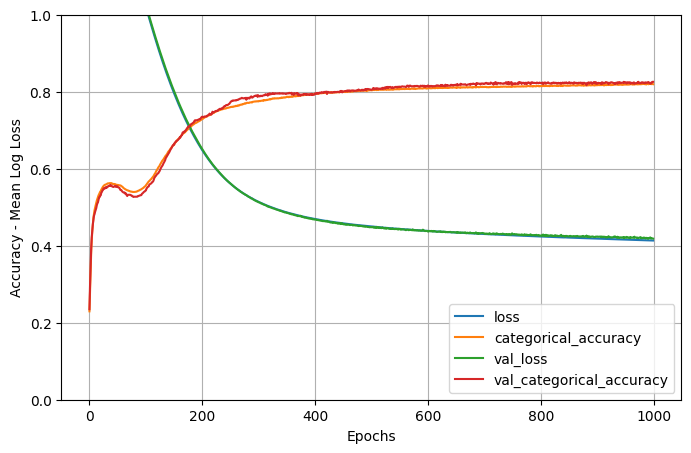

         loss  categorical_accuracy  val_loss  val_categorical_accuracy
999  0.413492              0.819648  0.418529                  0.825682

Error (training):  18.0 %
Error (development):  17.4 %

Accuracy (training):  81.96479678153992 %
Accuracy (development):  82.56824016571045 %


In [ ]:
n_neurons_per_hidden_layer = [500, 350, 250, 120, 75]
lr = 0.0001
activation = "relu"
n_epochs = 1000


final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs)


El bias es alto (8%) y varianza nula. Los resultados de esta primera ejecucion no son malos teniendo en cuenta que es el modelo esta en su version mas sencilla, pero hemos obtenido mejores y estos deberian ser tambien mejorables.

Hacemos uso de un optimizador.

###NAG

Fit time:  0:07:22.662330

Development loss: 0.4294077754020691
Development categorical accuracy: 0.8207195997238159
Classification Report
              precision    recall  f1-score   support

        Poor       0.91      0.87      0.89       439
      Interm       0.74      0.73      0.74       408
        Good       0.76      0.79      0.78       434
       Excel       0.88      0.90      0.89       331

    accuracy                           0.82      1612
   macro avg       0.82      0.82      0.82      1612
weighted avg       0.82      0.82      0.82      1612



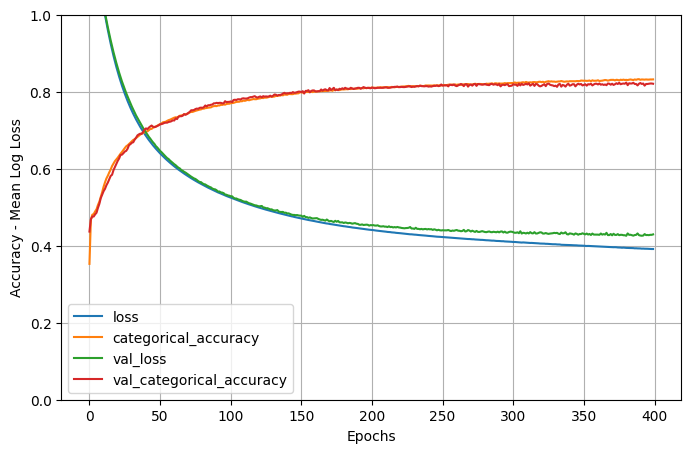

         loss  categorical_accuracy  val_loss  val_categorical_accuracy
399  0.391452              0.832054  0.429408                   0.82072

Error (training):  16.8 %
Error (development):  17.9 %

Accuracy (training):  83.20539593696594 %
Accuracy (development):  82.07195997238159 %


In [ ]:
n_neurons_per_hidden_layer = [500, 350, 250, 120, 75]
lr = 0.0001
activation = "relu"
n_epochs = 400

kwargs = {'optimizer': tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.85, nesterov=True),
          'initializer': keras.initializers.he_uniform(seed=127)
          }

final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs, **kwargs)

Hemos reducido ligeramente el bias a un 6.8%,  la varianza es de 1.1%. Este modelo esta lejos de ser de los mejores. Aplicamos un legularizador para tratar de disminuir la varianza.

####REG. L1_L2

Fit time:  0:11:22.961774

Development loss: 2.7039713859558105
Development categorical accuracy: 0.7959057092666626
Classification Report
              precision    recall  f1-score   support

        Poor       0.89      0.88      0.89       439
      Interm       0.73      0.68      0.70       408
        Good       0.72      0.76      0.74       434
       Excel       0.85      0.87      0.86       331

    accuracy                           0.80      1612
   macro avg       0.80      0.80      0.80      1612
weighted avg       0.80      0.80      0.80      1612



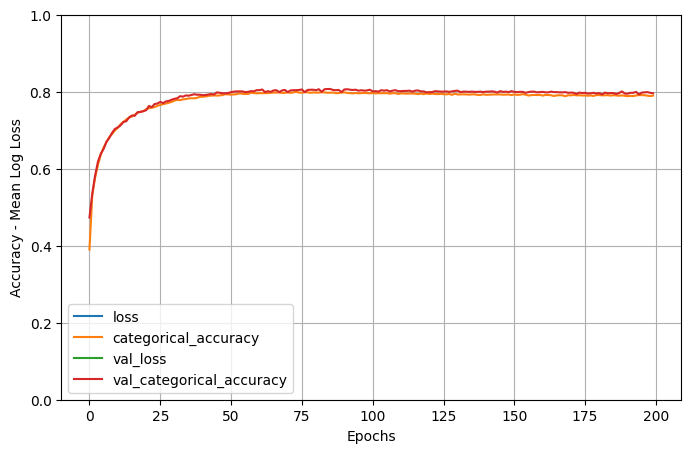

         loss  categorical_accuracy  val_loss  val_categorical_accuracy
199  2.723225              0.789874  2.703971                  0.795906

Error (training):  21.0 %
Error (development):  20.4 %

Accuracy (training):  78.98736000061035 %
Accuracy (development):  79.59057092666626 %


In [ ]:
n_neurons_per_hidden_layer = [500, 350, 250, 120, 75]
lr = 0.0001
activation = "relu"
n_epochs = 200

kwargs = {'optimizer': tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.85, nesterov=True),
          'initializer': keras.initializers.he_uniform(seed=127),
          'regularizer': keras.regularizers.l1_l2(0.001)
          }

final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs, **kwargs)

No importa el regularizador usado que obtenemos unos resultados bastante malos, con una accuracy baja y una loss altisima (2.7 tanto en entrenamiento como en validacion). Como no logramos disminuir la varianza mediante el uso de regularizadores haremos uso de dropout, que ahora si que lo vemos utilizable al tener una red neuronal algo mas grande.

####DROPOUT

Escogemos una dropout rate pequeña puesto que la red neuronal tampoco es muy grande.

Fit time:  0:09:22.848583

Development loss: 0.40549030900001526
Development categorical accuracy: 0.8325061798095703
Classification Report
              precision    recall  f1-score   support

        Poor       0.89      0.91      0.90       439
      Interm       0.76      0.75      0.76       408
        Good       0.80      0.77      0.79       434
       Excel       0.89      0.90      0.89       331

    accuracy                           0.83      1612
   macro avg       0.83      0.83      0.83      1612
weighted avg       0.83      0.83      0.83      1612



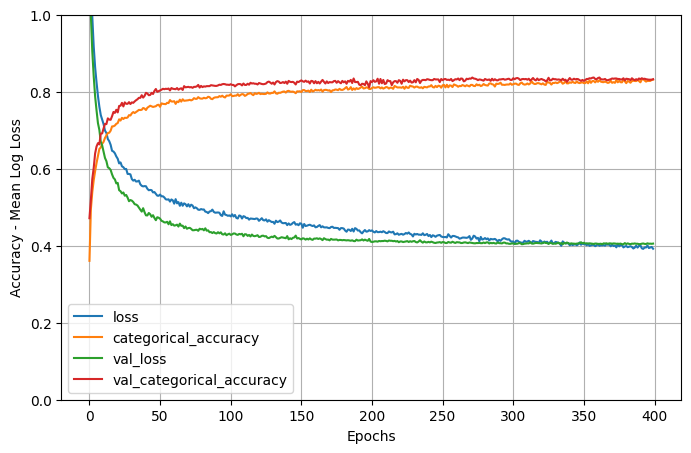

         loss  categorical_accuracy  val_loss  val_categorical_accuracy
399  0.392166              0.831279   0.40549                  0.832506

Error (training):  16.9 %
Error (development):  16.7 %

Accuracy (training):  83.12785625457764 %
Accuracy (development):  83.25061798095703 %


In [ ]:
n_neurons_per_hidden_layer = [500, 350, 250, 120, 75]
lr = 0.0005
activation = "relu"
n_epochs = 400

kwargs = {'optimizer': tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True),
          'initializer': keras.initializers.he_uniform(seed=127),
          'dropout': 0.1,
          'batch_size': 128
          }

final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs, **kwargs)

Obtenemos un modelo bastante bueno, aun asi no mejora el encontrado con la arquitectura anterior, pero lo iguala. Obtenemos en validacion una accuracy del 83.25%. 

###RMSProp

Fit time:  0:01:23.751291

Development loss: 0.39797037839889526
Development categorical accuracy: 0.8294044733047485
Classification Report
              precision    recall  f1-score   support

        Poor       0.90      0.91      0.90       439
      Interm       0.76      0.75      0.76       408
        Good       0.79      0.76      0.78       434
       Excel       0.88      0.90      0.89       331

    accuracy                           0.83      1612
   macro avg       0.83      0.83      0.83      1612
weighted avg       0.83      0.83      0.83      1612



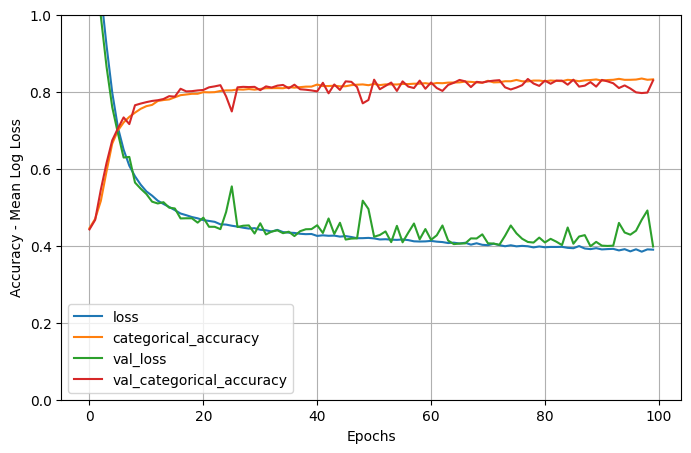

        loss  categorical_accuracy  val_loss  val_categorical_accuracy
99  0.389764              0.832132   0.39797                  0.829404

Error (training):  16.8 %
Error (development):  17.1 %

Accuracy (training):  83.21315050125122 %
Accuracy (development):  82.94044733047485 %


In [ ]:
n_neurons_per_hidden_layer = [500, 350, 250, 120, 75]
lr = 0.0001
activation = "relu"
n_epochs = 100

kwargs = {'optimizer': tf.keras.optimizers.RMSprop(learning_rate=lr, rho=0.9),
          'batch_size': 512
                  }

final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs, **kwargs)

Obtenemos buenos resultados pero no mejoran los anterirores. Ademas la grafica se ve muy inestable.

Este optimizador no parece ser el mas adecuado. Tambien probamos con Adam y obtenemos resultados similares a este si no peores.

##[750,500,250,75,25]

Fit time:  0:13:33.479341

Development loss: 0.3961574137210846
Development categorical accuracy: 0.8368486166000366
Classification Report
              precision    recall  f1-score   support

        Poor       0.89      0.92      0.91       439
      Interm       0.77      0.75      0.76       408
        Good       0.80      0.78      0.79       434
       Excel       0.90      0.90      0.90       331

    accuracy                           0.84      1612
   macro avg       0.84      0.84      0.84      1612
weighted avg       0.84      0.84      0.84      1612



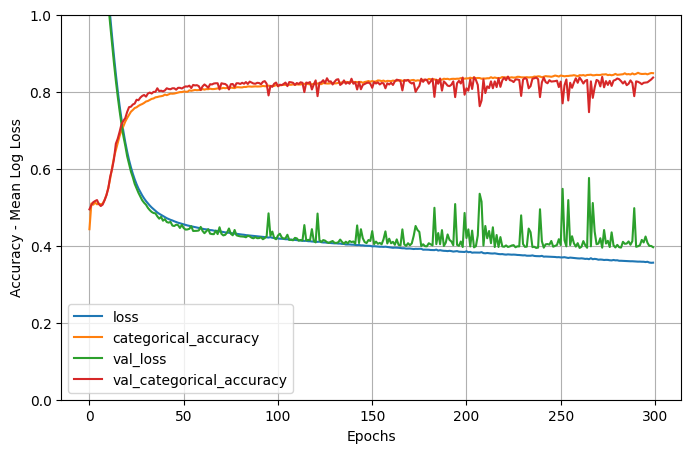

         loss  categorical_accuracy  val_loss  val_categorical_accuracy
299  0.355974              0.848182  0.396157                  0.836849

Error (training):  15.2 %
Error (development):  16.3 %

Accuracy (training):  84.81817245483398 %
Accuracy (development):  83.68486166000366 %


In [ ]:
n_neurons_per_hidden_layer = [750,500, 250, 75, 25]
lr = 0.001
activation = "relu"
n_epochs = 300


final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs)

En una primera ejecucion obtenemos valores sorprendentemente buenos, obteniendo la mejor accuracy en validacion hasta el momento, 83.68%.

En la grafica podemos ver como la loss comienza a aumentar en forma de zigzag. Trataremos de solventarlo disminuyendo la learning rate, ya que parece que era muy elevada para nuestro problema (objetivamente es una lr pequeña).

El bias es bajo (5.2%) pero la varianza es de 1.1%. Posiblemente nos encontremos ante el mejor modelo hasta ahora. 



Fit time:  0:12:22.798375

Development loss: 0.3992866277694702
Development categorical accuracy: 0.8325061798095703
Classification Report
              precision    recall  f1-score   support

        Poor       0.89      0.91      0.90       439
      Interm       0.77      0.74      0.75       408
        Good       0.79      0.79      0.79       434
       Excel       0.89      0.92      0.90       331

    accuracy                           0.83      1612
   macro avg       0.83      0.84      0.83      1612
weighted avg       0.83      0.83      0.83      1612



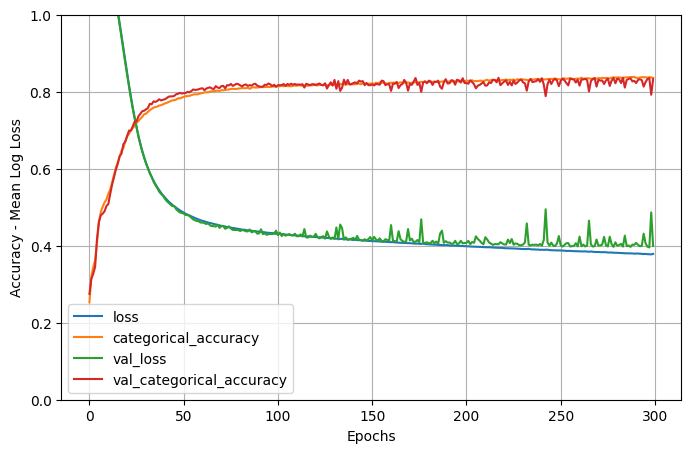

         loss  categorical_accuracy  val_loss  val_categorical_accuracy
299  0.378791              0.836008  0.399287                  0.832506

Error (training):  16.4 %
Error (development):  16.7 %

Accuracy (training):  83.6008369922638 %
Accuracy (development):  83.25061798095703 %


In [ ]:
n_neurons_per_hidden_layer = [750,500, 250, 75, 25]
lr = 0.0007
activation = "relu"
n_epochs = 300


final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs)

###NAG

Fit time:  0:16:13.720974

Development loss: 0.39568933844566345
Development categorical accuracy: 0.8331265449523926
Classification Report
              precision    recall  f1-score   support

        Poor       0.92      0.88      0.90       439
      Interm       0.76      0.75      0.76       408
        Good       0.77      0.81      0.79       434
       Excel       0.89      0.90      0.90       331

    accuracy                           0.83      1612
   macro avg       0.84      0.84      0.84      1612
weighted avg       0.83      0.83      0.83      1612



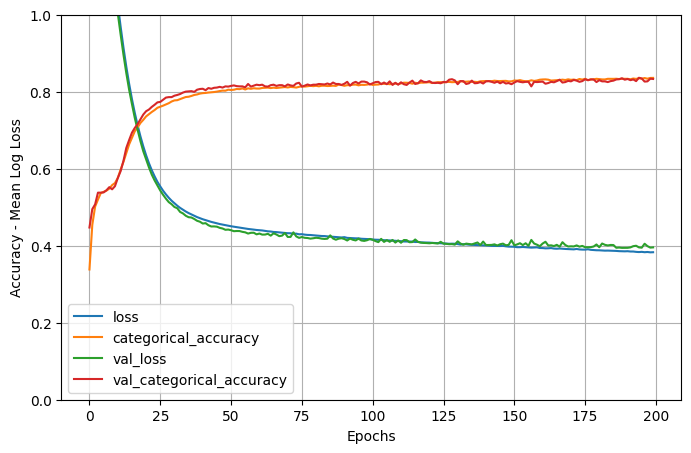

         loss  categorical_accuracy  val_loss  val_categorical_accuracy
199  0.383111              0.835931  0.395689                  0.833127

Error (training):  16.4 %
Error (development):  16.7 %

Accuracy (training):  83.59308242797852 %
Accuracy (development):  83.31265449523926 %


In [ ]:
n_neurons_per_hidden_layer = [750,500, 250, 75, 25]
lr = 0.0001
activation = "relu"
n_epochs = 200
kwargs = {'optimizer':tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)

}

final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs, **kwargs)

Obtenemos unos buenos resultados, pero no mejores que algunos obtenidos con otras arquitecturas

###RMSProp

Fit time:  0:04:22.727274

Development loss: 0.4480109214782715
Development categorical accuracy: 0.8083126544952393
Classification Report
              precision    recall  f1-score   support

        Poor       0.92      0.85      0.89       439
      Interm       0.75      0.73      0.74       408
        Good       0.74      0.77      0.76       434
       Excel       0.83      0.90      0.86       331

    accuracy                           0.81      1612
   macro avg       0.81      0.81      0.81      1612
weighted avg       0.81      0.81      0.81      1612



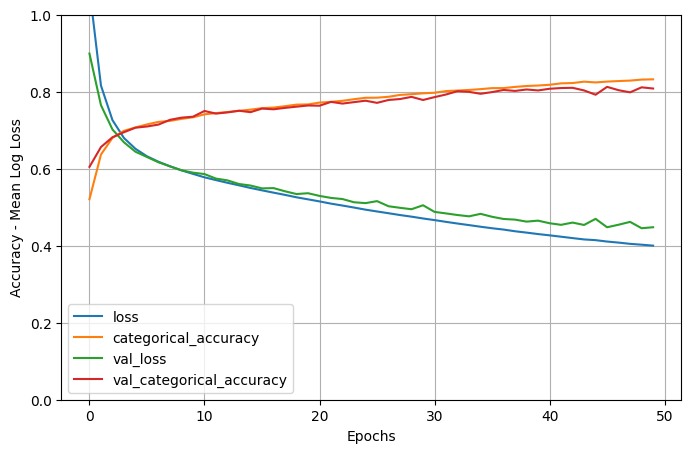

        loss  categorical_accuracy  val_loss  val_categorical_accuracy
49  0.400221              0.832209  0.448011                  0.808313

Error (training):  16.8 %
Error (development):  19.2 %

Accuracy (training):  83.2209050655365 %
Accuracy (development):  80.83126544952393 %


In [ ]:

n_neurons_per_hidden_layer = [750,500, 250, 75, 25]
lr = 0.00001
activation = "relu"
n_epochs = 50
kwargs = {'optimizer': tf.keras.optimizers.RMSprop(learning_rate=lr, rho=0.9),
          'initializer': keras.initializers.he_uniform(seed=127)
      
}

final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs, **kwargs)

####REG L1

Fit time:  0:04:23.522911

Development loss: 0.8414293527603149
Development categorical accuracy: 0.8052108883857727
Classification Report
              precision    recall  f1-score   support

        Poor       0.94      0.83      0.88       439
      Interm       0.73      0.72      0.72       408
        Good       0.74      0.77      0.75       434
       Excel       0.83      0.93      0.88       331

    accuracy                           0.81      1612
   macro avg       0.81      0.81      0.81      1612
weighted avg       0.81      0.81      0.81      1612



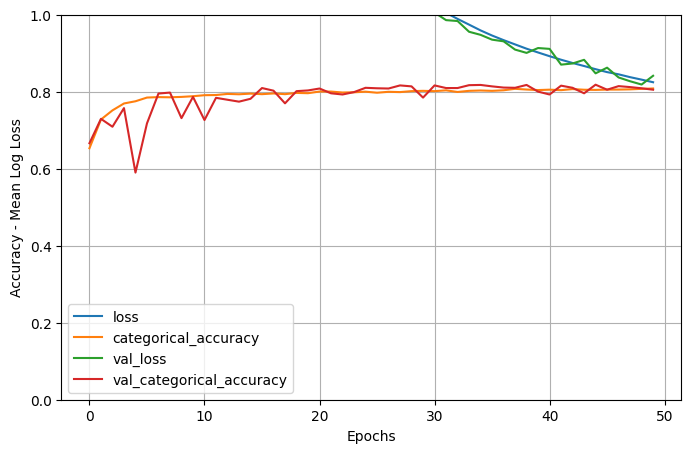

        loss  categorical_accuracy  val_loss  val_categorical_accuracy
49  0.824653              0.808405  0.841429                  0.805211

Error (training):  19.2 %
Error (development):  19.5 %

Accuracy (training):  80.84050416946411 %
Accuracy (development):  80.52108883857727 %


In [ ]:

n_neurons_per_hidden_layer = [750,500, 250, 75, 25]
lr = 0.0001
activation = "relu"
n_epochs = 50
kwargs = {'optimizer': tf.keras.optimizers.RMSprop(learning_rate=lr, rho=0.9),
          'initializer': keras.initializers.he_uniform(seed=127),
          'regularizer': keras.regularizers.l1(0.001)

}

final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs, **kwargs)

Una vez hemos aumentado considerablemente la complejidad del modelo y no vemos que la accuracy mejore mucho respecto a modelos mas simples optamos por probar con arquitecturas distintas a la de embudo.

En primer lugar probamos con una arquitectura simetrica.

La varianza es nula y el bias alto (9.4%), tratamos de disminuirlo mediante el uso de un optimizador.

#ARQUITECTURA ALTERNADA

Finalmente probamos con una estructura que alterna entre 2 capas con diferente numero de neuronas, una tiene 500 y la otra la mitad, 250. Se van alternando sucesivamente el numero de neuronas por capa.

## [200,100,200,100,200]

Fit time:  0:20:09.576074

Development loss: 0.4258904755115509
Development categorical accuracy: 0.8145161271095276
Classification Report
              precision    recall  f1-score   support

        Poor       0.90      0.87      0.89       439
      Interm       0.74      0.72      0.73       408
        Good       0.75      0.79      0.77       434
       Excel       0.87      0.89      0.88       331

    accuracy                           0.81      1612
   macro avg       0.82      0.82      0.82      1612
weighted avg       0.82      0.81      0.81      1612



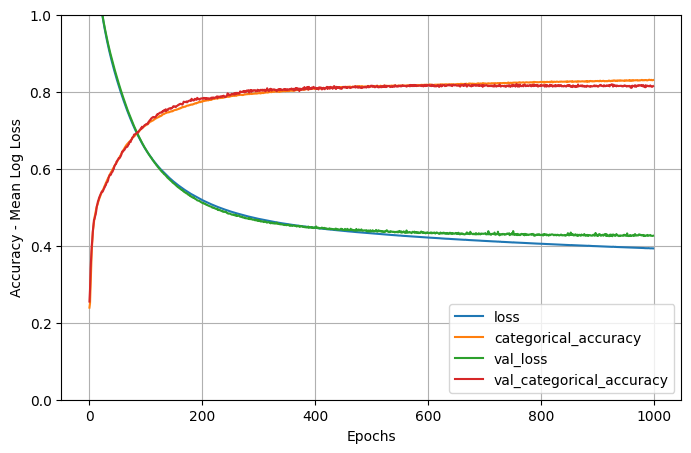

         loss  categorical_accuracy  val_loss  val_categorical_accuracy
999  0.393036              0.830271   0.42589                  0.814516

Error (training):  17.0 %
Error (development):  18.5 %

Accuracy (training):  83.02705883979797 %
Accuracy (development):  81.45161271095276 %


In [ ]:
n_neurons_per_hidden_layer = [200,100,200,100,200]
lr = 0.0001
activation = "relu"
n_epochs = 1000

kwargs = {
          'initializer': keras.initializers.he_uniform(seed=127)
          }

final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs, **kwargs)

En una primera ejecucion obtenemos valores relativamente buenoS con un bias de un 7% y una varianza de 1.5%. Tratamos de mejorar el bias con el uso de un optimizador


###NAG

Fit time:  0:03:03.076810

Development loss: 0.43624359369277954
Development categorical accuracy: 0.8114144206047058
Classification Report
              precision    recall  f1-score   support

        Poor       0.91      0.87      0.89       439
      Interm       0.74      0.75      0.74       408
        Good       0.78      0.71      0.75       434
       Excel       0.82      0.95      0.88       331

    accuracy                           0.81      1612
   macro avg       0.81      0.82      0.81      1612
weighted avg       0.81      0.81      0.81      1612



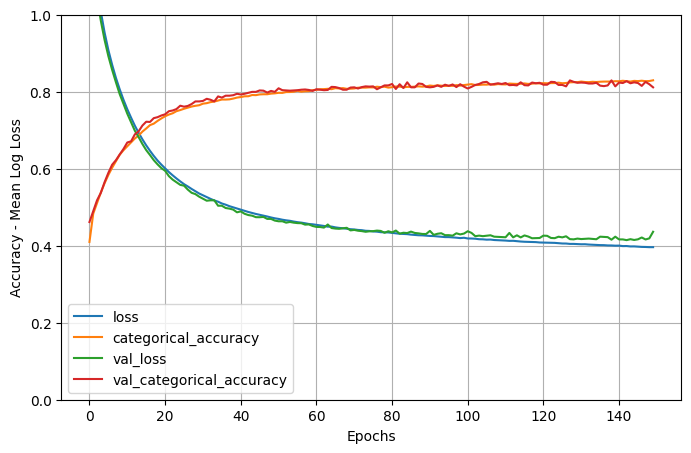

         loss  categorical_accuracy  val_loss  val_categorical_accuracy
149  0.396279               0.82965  0.436244                  0.811414

Error (training):  17.0 %
Error (development):  18.9 %

Accuracy (training):  82.96502828598022 %
Accuracy (development):  81.14144206047058 %


In [ ]:
n_neurons_per_hidden_layer = [200,100,200,100,200]
lr = 0.0001
activation = "relu"
n_epochs = 130

kwargs = {
          'initializer': keras.initializers.he_uniform(seed=127),
          'optimizer': tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.85, nesterov=True)
          }

final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs, **kwargs)

-----------COMENTAR---------------

###RMSProp

In [ ]:
n_neurons_per_hidden_layer = [200,100,200,100,200]
lr = 0.0001
activation = "relu"
n_epochs = 130

kwargs = {
          'initializer': keras.initializers.he_uniform(seed=127),
          'optimizer': tf.keras.optimizers.RMSprop(learning_rate=lr, rho=0.9)
          }

final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs, **kwargs)

Fit time:  0:02:36.827527

Development loss: 1.0942459106445312
Development categorical accuracy: 0.789081871509552
Classification Report
              precision    recall  f1-score   support

        Poor       0.88      0.86      0.87       439
      Interm       0.69      0.71      0.70       408
        Good       0.75      0.71      0.73       434
       Excel       0.85      0.90      0.87       331

    accuracy                           0.79      1612
   macro avg       0.79      0.79      0.79      1612
weighted avg       0.79      0.79      0.79      1612



###ADAM

Fit time:  0:01:24.018542

Development loss: 0.5941770672798157
Development categorical accuracy: 0.8182381987571716
Classification Report
              precision    recall  f1-score   support

        Poor       0.88      0.91      0.89       439
      Interm       0.76      0.71      0.73       408
        Good       0.76      0.77      0.77       434
       Excel       0.88      0.89      0.88       331

    accuracy                           0.82      1612
   macro avg       0.82      0.82      0.82      1612
weighted avg       0.82      0.82      0.82      1612



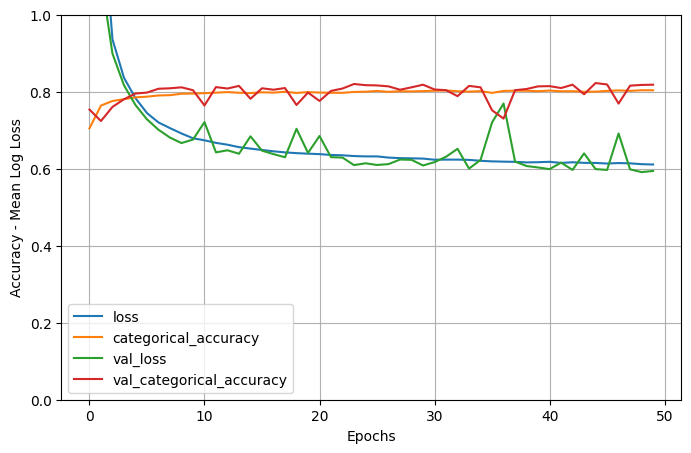

        loss  categorical_accuracy  val_loss  val_categorical_accuracy
49  0.610957              0.803753  0.594177                  0.818238

Error (training):  19.6 %
Error (development):  18.2 %

Accuracy (training):  80.37528395652771 %
Accuracy (development):  81.82381987571716 %


In [ ]:
n_neurons_per_hidden_layer = [200,100,200,100,200]
lr = 0.001
activation = "relu"
n_epochs = 50

kwargs = {
          'initializer': keras.initializers.he_uniform(seed=127),
          'optimizer': tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.6, beta_2=0.9),
          'regularizer': keras.regularizers.l1_l2(0.001)

          }

final_model = create_classif_model('name',n_neurons_per_hidden_layer, lr, activation, n_epochs, **kwargs)